In [1]:

# # Cell 2: Imports
# import os
# import base64
# import io
# import glob
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import random
# from itertools import count
# from PIL import Image
# from collections import deque, namedtuple
# from scipy.stats import norm, t
# from scipy.stats import ttest_ind
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.transforms as T
# import torch.optim as optim
# import gymnasium as gym
# import highway_env
# from gymnasium.wrappers import RecordVideo
# from IPython.display import HTML
# from IPython import display
# plt.style.use('ggplot')
# %matplotlib inline

# # Cell 3: Hyperparameters & Paths
# BUFFER_SIZE = int(5e4)  # Reduced for CPU stability
# BATCH_SIZE = 64
# GAMMA = 0.99
# TAU = 1e-3
# LR = 5e-4
# UPDATE_EVERY = 4
# path_HW5 = r"C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks"
# if not path_HW5.endswith(os.sep):
#     path_HW5 += os.sep
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")
# for subdir in ['Models', 'Data_Average_Reward', 'Videos', 'Images']:
#     os.makedirs(os.path.join(path_HW5, subdir), exist_ok=True)

# # Cell 4: Neural Network Architectures
# class QNetwork_Linear(nn.Module):
#     def __init__(self, state_size, action_size, seed):
#         super(QNetwork_Linear, self).__init__()
#         torch.manual_seed(seed)
#         self.fc1 = nn.Linear(state_size, 125)
#         self.fc2 = nn.Linear(125, 125)
#         self.fc3 = nn.Linear(125, action_size)

#     def forward(self, state):
#         x = F.relu(self.fc1(state))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# class QNetwork_CNN(nn.Module):
#     def __init__(self, action_size, seed):
#         super(QNetwork_CNN, self).__init__()
#         torch.manual_seed(seed)
#         self.conv1 = nn.Conv2d(3, 128, kernel_size=3)
#         self.conv2 = nn.Conv2d(128, 128, kernel_size=3)
#         self.maxpool = nn.MaxPool2d(kernel_size=2)
#         self.dropout = nn.Dropout(0.1)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(38912, 64)
#         self.fc2 = nn.Linear(64, action_size)

#     def forward(self, state):
#         x = self.dropout(self.maxpool(F.relu(self.conv1(state))))
#         x = self.dropout(self.maxpool(F.relu(self.conv2(x))))
#         x = self.flatten(x)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Cell 5: Replay Buffer
# class ReplayBuffer:
#     def __init__(self, action_size, buffer_size, batch_size, seed):
#         self.action_size = action_size
#         self.memory = deque(maxlen=buffer_size)
#         self.batch_size = batch_size
#         self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
#         random.seed(seed)

#     def add(self, state, action, reward, next_state, done):
#         e = self.experience(state, action, reward, next_state, done)
#         self.memory.append(e)

#     def sample(self):
#         experiences = random.sample(self.memory, k=self.batch_size)
#         states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
#         actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
#         rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
#         next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
#         dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
#         return (states, actions, rewards, next_states, dones)

#     def __len__(self):
#         return len(self.memory)

# # Cell 6: Agent
# class Agent:
#     def __init__(self, state_size, action_size, network_type, seed):
#         self.state_size = state_size
#         self.action_size = action_size
#         random.seed(seed)
#         self.network_type = network_type.lower()
#         if self.network_type == 'linear':
#             self.qnetwork_local = QNetwork_Linear(state_size, action_size, seed).to(device)
#             self.qnetwork_target = QNetwork_Linear(state_size, action_size, seed).to(device)
#         else:
#             self.qnetwork_local = QNetwork_CNN(action_size, seed).to(device)
#             self.qnetwork_target = QNetwork_CNN(action_size, seed).to(device)
#         self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
#         self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
#         self.t_step = 0
#         self.resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.Resampling.BICUBIC), T.ToTensor()])

#     def get_screen(self, screen):
#         screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
#         screen = torch.from_numpy(screen).permute(2, 0, 1)
#         return self.resize(screen).unsqueeze(0)

#     def step(self, state, action, reward, next_state, done):
#         self.memory.add(state, action, reward, next_state, done)
#         self.t_step = (self.t_step + 1) % UPDATE_EVERY
#         if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
#             experiences = self.memory.sample()
#             self.learn(experiences, GAMMA)

#     def act(self, state, eps=0):
#         if self.network_type == 'linear':
#             state = torch.from_numpy(state).float().unsqueeze(0).to(device)
#         else:
#             state = state.to(device)
#         self.qnetwork_local.eval()
#         with torch.no_grad():
#             action_values = self.qnetwork_local(state)
#         self.qnetwork_local.train()
#         if random.random() > eps:
#             return np.argmax(action_values.cpu().data.numpy())
#         return random.choice(np.arange(self.action_size))

#     def learn(self, experiences, gamma):
#         states, actions, rewards, next_states, dones = experiences
#         q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
#         q_targets = rewards + gamma * q_targets_next * (1 - dones)
#         q_expected = self.qnetwork_local(states).gather(1, actions)
#         loss = F.mse_loss(q_expected, q_targets)
#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()
#         self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

#     def soft_update(self, local_model, target_model, tau):
#         for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
#             target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

# # Cell 7: DQN
# class DQN:
#     def __init__(self, env, env_name, model_path, data_path, network_type, env_name_source=None, model_path_source=None, transfer_episode=None):
#         self.env = env.unwrapped
#         self.env_name = env_name
#         self.model_path = model_path
#         self.data_path = data_path
#         self.network_type = network_type.lower()
#         self.env_name_source = env_name_source
#         self.model_path_source = model_path_source
#         self.transfer_episode = transfer_episode
#         self.df_reward = pd.DataFrame()
#         self.seed = [0, 5, 11, 123, 487]
#         self.env.config['policy_frequency'] = self.env.config.get('policy_frequency', 10)

#     def train_with_state(self, n_iteration, n_training_episodes=50, max_step=10000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
#         print(f"Training agent with state for {self.env_name}...")
#         if n_iteration[0] != 1:
#             prev_file = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
#             if os.path.exists(prev_file):
#                 self.df_reward = pd.read_excel(prev_file)

#         for iter in tqdm(n_iteration, desc="Iterations"):
#             episodes_reward = []
#             state_size = int(np.prod(self.env.observation_space.shape))
#             action_size = self.env.action_space.n
#             agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])
#             if self.env_name_source and self.model_path_source and self.transfer_episode:
#                 local_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_local_{self.transfer_episode}.pth')
#                 target_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_target_{self.transfer_episode}.pth')
#                 if os.path.exists(local_path) and os.path.exists(target_path):
#                     agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
#                     agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
#                 else:
#                     print(f"Warning: Transfer models not found at {local_path} or {target_path}")

#             os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
#             eps = eps_start

#             for episode_num in tqdm(range(1, n_training_episodes + 1), desc=f"Iter {iter} Episodes", leave=False):
#                 eps = max(eps_end, eps_decay * eps)
#                 state, _ = self.env.reset()
#                 done = False
#                 total_reward = 0
#                 for _ in range(max_step):
#                     action = agent.act(state.ravel(), eps)
#                     next_state, reward, terminated, truncated, _ = self.env.step(action)
#                     total_reward += reward
#                     agent.step(state.ravel(), action, reward, next_state.ravel(), terminated or truncated)
#                     if terminated or truncated:
#                         break
#                     state = next_state
#                 episodes_reward.append(total_reward)
#                 print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}', end='')
#                 if episode_num % 10 == 0:
#                     print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}')
#                     self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
#                     self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)
#                 if episode_num % 200 == 0:
#                     torch.save(agent.qnetwork_local.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_local_{episode_num}.pth'))
#                     torch.save(agent.qnetwork_target.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_target_{episode_num}.pth'))

#             self.df_reward[f'Run_{iter}'] = episodes_reward
#             self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
#             temp_file = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
#             if os.path.exists(temp_file):
#                 os.remove(temp_file)
#         return self.df_reward

#     def train_with_observation(self, n_iteration, n_training_episodes=50, max_step=10000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
#         print(f"Training agent with observation for {self.env_name}...")
#         if n_iteration[0] != 1:
#             prev_file = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
#             if os.path.exists(prev_file):
#                 self.df_reward = pd.read_excel(prev_file)

#         for iter in tqdm(n_iteration, desc="Iterations"):
#             episodes_reward = []
#             state_size = int(np.prod(self.env.observation_space.shape))
#             action_size = self.env.action_space.n
#             agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])
#             if self.env_name_source and self.model_path_source and self.transfer_episode:
#                 local_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name_source}_local_{self.transfer_episode}.pth')
#                 target_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name_source}_target_{self.transfer_episode}.pth')
#                 if os.path.exists(local_path) and os.path.exists(target_path):
#                     agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
#                     agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
#                 else:
#                     print(f"Warning: Transfer models not found at {local_path} or {target_path}")

#             os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
#             eps = eps_start

#             for episode_num in tqdm(range(1, n_training_episodes + 1), desc=f"Iter {iter} Episodes", leave=False):
#                 eps = max(eps_end, eps_decay * eps)
#                 self.env.reset()
#                 last_screen = agent.get_screen(self.env.render())
#                 current_screen = agent.get_screen(self.env.render())
#                 state = current_screen - last_screen
#                 done = False
#                 total_reward = 0
#                 for _ in range(max_step):
#                     action = agent.act(state, eps)
#                     _, reward, terminated, truncated, _ = self.env.step(action)
#                     total_reward += reward
#                     last_screen = current_screen
#                     current_screen = agent.get_screen(self.env.render())
#                     next_state = current_screen - last_screen
#                     agent.step(state, action, reward, next_state, terminated or truncated)
#                     if terminated or truncated:
#                         break
#                     state = next_state
#                 episodes_reward.append(total_reward)
#                 print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}', end='')
#                 if episode_num % 10 == 0:
#                     print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}')
#                     self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
#                     self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)
#                 if episode_num % 200 == 0:
#                     torch.save(agent.qnetwork_local.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name}_local_{episode_num}.pth'))
#                     torch.save(agent.qnetwork_target.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name}_target_{episode_num}.pth'))

#             self.df_reward[f'Run_{iter}'] = episodes_reward
#             self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
#             temp_file = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
#             if os.path.exists(temp_file):
#                 os.remove(temp_file)
#         return self.df_reward

#     def evaluation(self, video_file, evaluate_type, iter_num, evaluate_episode_num, use_saved_model=True, num_episodes=5):
#         video_dir = os.path.dirname(video_file)
#         os.makedirs(video_dir, exist_ok=True)
#         os.environ["SDL_VIDEODRIVER"] = "windows"
#         state_size = int(np.prod(self.env.observation_space.shape))
#         action_size = self.env.action_space.n
#         agent = Agent(state_size, action_size, self.network_type, seed=11)

#         if use_saved_model:
#             local_path = os.path.join(self.model_path, f'Models_Run_{iter_num}', f'checkpoint_dqn_{evaluate_type}_{self.env_name}_local_{evaluate_episode_num}.pth')
#             target_path = os.path.join(self.model_path, f'Models_Run_{iter_num}', f'checkpoint_dqn_{evaluate_type}_{self.env_name}_target_{evaluate_episode_num}.pth')
#             if os.path.exists(local_path) and os.path.exists(target_path):
#                 agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
#                 agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
#             else:
#                 print(f"Error: Models not found at {local_path} or {target_path}. Ensure training completed.")
#                 return None

#         eval_rewards = []
#         for ep in range(num_episodes):
#             env_wrapped = RecordVideo(self.env, video_folder=video_dir, name_prefix=f"{self.env_name}_eval_ep{ep}")
#             frame = env_wrapped.render()
#             if frame is None or np.mean(frame) == 0:
#                 print(f"Warning: Empty frame in episode {ep}. Saving debug frame...")
#                 if frame is not None:
#                     imageio.imwrite(os.path.join(video_dir, f'debug_frame_ep{ep}.png'), frame)
#             if evaluate_type == 'state':
#                 state, _ = env_wrapped.reset()
#                 done = False
#                 ep_reward = 0
#                 while not done:
#                     action = agent.act(state.ravel(), eps=0)
#                     state, reward, terminated, truncated, _ = env_wrapped.step(action)
#                     ep_reward += reward
#                     done = terminated or truncated
#             else:
#                 env_wrapped.reset()
#                 last_screen = agent.get_screen(env_wrapped.render())
#                 current_screen = agent.get_screen(env_wrapped.render())
#                 state = current_screen - last_screen
#                 done = False
#                 ep_reward = 0
#                 while not done:
#                     action = agent.act(state, eps=0)
#                     _, reward, terminated, truncated, _ = env_wrapped.step(action)
#                     ep_reward += reward
#                     last_screen = current_screen
#                     current_screen = agent.get_screen(env_wrapped.render())
#                     state = current_screen - last_screen
#                     done = terminated or truncated
#             env_wrapped.close()
#             eval_rewards.append(ep_reward)
#             print(f"Episode {ep+1}/{num_episodes} Reward: {ep_reward:.2f}")

#         avg_reward = np.mean(eval_rewards)
#         print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
#         pd.DataFrame({'Episode': list(range(1, num_episodes+1)), 'Reward': eval_rewards}).to_csv(
#             os.path.join(video_dir, f"{self.env_name}_eval_rewards.csv"), index=False)
#         return avg_reward

# # Cell 8: Show and Plot
# class show_and_plot:
#     def __init__(self):
#         pass

#     def show_video(self, directory, file_name):
#         if not directory.endswith(os.sep):
#             directory += os.sep
#         mp4_path = os.path.join(directory, file_name)
#         print(f"Attempting to display video: {mp4_path}")
#         if os.path.exists(mp4_path):
#             try:
#                 with open(mp4_path, 'rb') as f:
#                     video = f.read()
#                 encoded = base64.b64encode(video)
#                 display.display(HTML(f'<video alt="test" autoplay loop controls style="height: 165px; width: 650px;"><source src="data:video/mp4;base64,{encoded.decode()}" type="video/mp4" /></video>'))
#             except Exception as e:
#                 print(f"Error displaying video {mp4_path}: {e}. Try opening the video in a media player.")
#         else:
#             print(f"Video not found: {mp4_path}. Available videos: {glob.glob(os.path.join(directory, '*.mp4'))}")

#     def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):
#         n_iter, n_episode = episodes_rewards.shape
#         smooth_reward = [np.mean(episodes_rewards[:, i*stride:i*stride+window], axis=1) for i in range(int((n_episode - window)/stride) + 1)]
#         smooth_reward = np.array(smooth_reward).T
#         X = range(1, len(smooth_reward[0])*stride + 1, stride)
#         x_bar = np.mean(smooth_reward, axis=0)
#         sigma = np.std(smooth_reward, axis=0)
#         SE = sigma / np.sqrt(n_iter)
#         interval = 1 - alpha
#         if n_iter < 30:
#             t_stat = t.interval(interval, df=n_iter-1)[1]
#             ME = t_stat * SE
#         else:
#             z_stat = norm.interval(interval)[1]
#             ME = z_stat * SE
#         ax.plot(X, x_bar, label=label)
#         if n_iter >= 2:
#             ax.fill_between(X, x_bar - ME, x_bar + ME, alpha=alpha)
#         ax.set_xlabel("Episodes")
#         ax.set_ylabel("Average Reward")
#         ax.set_title(f"{title}\nwindow={window}, stride={stride}")
#         return ax

# # Cell 9: Part 1 - Environment Setup and Visualization
# print("Visualizing highway-v0 environment...")
# env = gym.make('highway-v0', render_mode='rgb_array')
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 10,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })
# try:
#     obs, _ = env.reset()
#     frame = env.render()
#     print("Highway-v0 Frame shape:", frame.shape if frame is not None else "None")
#     print("Frame sample (top-left):", frame[0, 0, :] if frame is not None else "None")
#     print("Frame mean:", np.mean(frame) if frame is not None else "None")
#     if frame is not None and not np.all(frame == 0):
#         imageio.imwrite(os.path.join(path_HW5, 'Videos', 'debug_frame_highway-v0.png'), frame)
#         plt.imshow(frame)
#         plt.title("Highway-v0 Sample Frame")
#         plt.show()
#     else:
#         print("Warning: Black or empty frame for highway-v0")
# except Exception as e:
#     print(f"Error during highway-v0 rendering: {str(e)}")
# finally:
#     env.close()

# # Cell 10: Part 2 - Merge-v0
# video_path = os.path.join(path_HW5, 'Videos')
# model_path = os.path.join(path_HW5, 'Models/1_Models_merge')
# data_path_1 = os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge')
# env_name = 'merge-v0'
# env = gym.make(env_name, render_mode='rgb_array')
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 10,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })
# dqn_merge = DQN(env, env_name, model_path, data_path_1, 'linear')

# # Training
# print("Starting training for Cell 10 (Merge-v0)...")
# df_reward_merge = dqn_merge.train_with_state(n_iteration=[1,2,3,4,5], n_training_episodes=50)

# # Evaluation
# print("Starting evaluation for Cell 10...")
# avg_reward = dqn_merge.evaluation(os.path.join(video_path, "merge.mp4"), 'state', iter_num=5, evaluate_episode_num=200)
# show_and_plot().show_video(video_path, "merge-v0_eval_ep0-episode-0.mp4")

# # Plotting
# print("Generating plot for Cell 10...")
# df_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_5.xlsx'))
# ep_merge = df_merge.T.to_numpy()
# fig, ax = plt.subplots(figsize=(12, 7.5))
# ax = show_and_plot().plot_training_result(ep_merge, ax, 'DQN Merge', 'Merge task with state', window=10, stride=2)
# plt.legend()
# plt.show()
# fig.savefig(os.path.join(path_HW5, 'Images/1-Merge-task-state.png'), dpi=300)

# # Cell 11: Part 3 - Highway-Fast-v0
# video_path = os.path.join(path_HW5, 'Videos')
# model_path = os.path.join(path_HW5, 'Models/2_Models_fastHighway')
# data_path_2 = os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway')
# env_name = 'highway-fast-v0'
# env = gym.make(env_name, render_mode='rgb_array')
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 5,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })
# dqn_fastHighway = DQN(env, env_name, model_path, data_path_2, 'linear')

# # Training
# print("Starting training for Cell 11...")
# df_reward_fast = dqn_fastHighway.train_with_state(n_iteration=[1,2,3,4,5], n_training_episodes=50)

# # Evaluation
# print("Starting evaluation for Cell 11...")
# avg_reward = dqn_fastHighway.evaluation(os.path.join(video_path, "fastHighway.mp4"), 'state', iter_num=5, evaluate_episode_num=200)
# show_and_plot().show_video(video_path, "highway-fast-v0_eval_ep0-episode-0.mp4")

# # Cell 12: Part 3 - Transfer Learning
# model_path_source = os.path.join(path_HW5, 'Models/1_Models_merge')
# model_path_dest = os.path.join(path_HW5, 'Models/3_Models_merge_transfer_learning_to_fastHighway')
# data_path_3 = os.path.join(path_HW5, 'Data_Average_Reward/3_Data_merge_transfer_learning_to_fastHighway')
# env_name_source = 'merge-v0'
# env = gym.make('highway-fast-v0', render_mode='rgb_array')
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 5,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })

# # Check if source models exist
# print("Checking for source models for Cell 12...")
# for iter in range(1, 6):
#     local_path = os.path.join(model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{env_name_source}_local_200.pth')
#     target_path = os.path.join(model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{env_name_source}_target_200.pth')
#     if not os.path.exists(local_path) or not os.path.exists(target_path):
#         print(f"Error: Source model {local_path} or {target_path} not found. Run Cell 10 first.")
#         raise FileNotFoundError(f"Missing {local_path} or {target_path}")

# dqn_transfer = DQN(env, 'highway-fast-v0', model_path_dest, data_path_3, 'linear', env_name_source, model_path_source, transfer_episode=200)

# # Training
# print("Starting training for Cell 12...")
# df_reward_transfer = dqn_transfer.train_with_state(n_iteration=[1,2,3,4,5], n_training_episodes=50)

# # Evaluation
# print("Starting evaluation for Cell 12...")
# avg_reward = dqn_transfer.evaluation(os.path.join(video_path, "fastHighway_transferred_from_merge.mp4"), 'state', iter_num=5, evaluate_episode_num=200)
# show_and_plot().show_video(video_path, "highway-fast-v0_eval_ep0-episode-0.mp4")

# # Plot Comparison
# print("Generating comparison plot for Cell 12...")
# df_fast = pd.read_excel(os.path.join(data_path_2, 'Episodes_reward_run_5.xlsx'))
# df_trans = pd.read_excel(os.path.join(data_path_3, 'Episodes_reward_run_5.xlsx'))
# ep_fast = df_fast.T.to_numpy()
# ep_trans = df_trans.T.to_numpy()
# fig, ax = plt.subplots(figsize=(12, 7.5))
# ax = show_and_plot().plot_training_result(ep_fast, ax, 'DQN Fast', 'Fast Highway', window=10, stride=2)
# ax = show_and_plot().plot_training_result(ep_trans, ax, 'DQN Transfer', 'Transfer from Merge', window=10, stride=2)
# plt.legend()
# plt.show()
# fig.savefig(os.path.join(path_HW5, 'Images/2-fastHighway_with_and_without_transfer_learning_training_on-state.png'), dpi=300)

In [2]:
# %pip install --upgrade pip
# %pip install gymnasium==0.29.1 highway-env torch torchvision moviepy openpyxl tqdm pandas numpy matplotlib scipy pillow imageio opencv-python pygame

# Cell 2: Imports


In [3]:
import os
import base64
import io
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import count
from PIL import Image
from collections import deque, namedtuple
from scipy.stats import norm, t
from scipy.stats import ttest_ind
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import gymnasium as gym
import highway_env
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display
import imageio  # Added for saving debug images
plt.style.use('ggplot')
%matplotlib inline

# Cell 3: Hyperparameters & Paths

In [4]:
BUFFER_SIZE = int(1e4)  # Reduced from 5e4 to prevent memory issues
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4
path_HW5 = r"C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks"
if not path_HW5.endswith(os.sep):
    path_HW5 += os.sep
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
for subdir in ['Models', 'Data_Average_Reward', 'Videos', 'Images']:
    os.makedirs(os.path.join(path_HW5, subdir), exist_ok=True)

Using device: cpu


# Cell 4: Neural Network Architectures

In [5]:
# Define neural network architectures for DQN
class QNetwork_Linear(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork_Linear, self).__init__()
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 125)
        self.fc2 = nn.Linear(125, 125)
        self.fc3 = nn.Linear(125, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class QNetwork_CNN(nn.Module):
    def __init__(self, action_size, seed):
        super(QNetwork_CNN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(38912, 64)
        self.fc2 = nn.Linear(64, action_size)

    def forward(self, state):
        x = self.dropout(self.maxpool(self.relu(self.conv1(state))))
        x = self.dropout(self.maxpool(self.relu(self.conv2(x))))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Cell 5: Replay Buffer

In [6]:
# Define replay buffer for storing experiences
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# Cell 6: Agent

In [7]:
# Define DQN agent
class Agent:
    def __init__(self, state_size, action_size, network_type, seed):
        self.state_size = state_size
        self.action_size = action_size
        random.seed(seed)
        self.network_type = network_type.lower()
        if self.network_type == 'linear':
            self.qnetwork_local = QNetwork_Linear(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork_Linear(state_size, action_size, seed).to(device)
        else:
            self.qnetwork_local = QNetwork_CNN(action_size, seed).to(device)
            self.qnetwork_target = QNetwork_CNN(action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
        self.resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.Resampling.BICUBIC), T.ToTensor()])

    def get_screen(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen).permute(2, 0, 1)
        return self.resize(screen).unsqueeze(0)

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0):
        if self.network_type == 'linear':
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        else:
            state = state.to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

# Cell 7: DQN

In [8]:
class DQN:
    def __init__(self, env, env_name, model_path, data_path, network_type, env_name_source=None, model_path_source=None, transfer_episode=None):
        self.env = env.unwrapped
        self.env_name = env_name
        self.model_path = model_path
        self.data_path = data_path
        self.network_type = network_type.lower()
        self.env_name_source = env_name_source
        self.model_path_source = model_path_source
        self.transfer_episode = transfer_episode
        self.df_reward = pd.DataFrame()
        self.seed = [0, 5, 11, 123, 487]
        self.env.config['policy_frequency'] = self.env.config.get('policy_frequency', 10)

    def train_with_state(self, n_iteration, n_training_episodes, max_step, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print(f"Training agent with state for {self.env_name}...")
        try:
            if n_iteration[0] != 1:
                prev_file = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
                if os.path.exists(prev_file):
                    self.df_reward = pd.read_excel(prev_file)

            for iter in tqdm(n_iteration, desc="Iterations"):
                episodes_reward = []
                state_size = int(np.prod(self.env.observation_space.shape))
                action_size = self.env.action_space.n
                agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])
                if self.env_name_source and self.model_path_source and self.transfer_episode:
                    local_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_local_{self.transfer_episode}.pth')
                    target_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_target_{self.transfer_episode}.pth')
                    if os.path.exists(local_path) and os.path.exists(target_path):
                        agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
                        agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
                    else:
                        print(f"Warning: Transfer models not found at {local_path} or {target_path}")

                os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
                eps = eps_start

                for episode_num in tqdm(range(1, n_training_episodes + 1), desc=f"Iter {iter} Episodes", leave=False):
                    eps = max(eps_end, eps_decay * eps)
                    state, _ = self.env.reset()
                    done = False
                    total_reward = 0
                    for step in range(max_step):
                        action = agent.act(state.ravel(), eps)
                        next_state, reward, terminated, truncated, info = self.env.step(action)
                        total_reward += reward
                        print(f"crash{info.get('crashed', False)}")
                        print(f"over{terminated or truncated}")
                        print(f"Raw Reward: {reward}")
                        agent.step(state.ravel(), action, reward, next_state.ravel(), terminated or truncated)
                        if terminated or truncated:
                            break
                        state = next_state
                    episodes_reward.append(total_reward)
                    print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}', end='')
                    if episode_num % 5 == 0:
                        print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}')
                        self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
                        self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)
                    if episode_num % 10 == 0:  # Save every 10 episodes
                        torch.save(agent.qnetwork_local.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_local_{episode_num}.pth'))
                        torch.save(agent.qnetwork_target.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_target_{episode_num}.pth'))

                self.df_reward[f'Run_{iter}'] = episodes_reward
                self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
                temp_file = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
                if os.path.exists(temp_file):
                    os.remove(temp_file)
            return self.df_reward
        except Exception as e:
            print(f"Error in train_with_state: {str(e)}")
            raise

    def train_with_observation(self, n_iteration, n_training_episodes, max_step, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print(f"Training agent with observation for {self.env_name}...")
        try:
            if n_iteration[0] != 1:
                prev_file = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
                if os.path.exists(prev_file):
                    self.df_reward = pd.read_excel(prev_file)

            for iter in tqdm(n_iteration, desc="Iterations"):
                episodes_reward = []
                state_size = int(np.prod(self.env.observation_space.shape))
                action_size = self.env.action_space.n
                agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])
                if self.env_name_source and self.model_path_source and self.transfer_episode:
                    local_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name_source}_local_{self.transfer_episode}.pth')
                    target_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name_source}_target_{self.transfer_episode}.pth')
                    if os.path.exists(local_path) and os.path.exists(target_path):
                        agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
                        agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
                    else:
                        print(f"Warning: Transfer models not found at {local_path} or {target_path}")

                os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
                eps = eps_start

                for episode_num in tqdm(range(1, n_training_episodes + 1), desc=f"Iter {iter} Episodes", leave=False):
                    eps = max(eps_end, eps_decay * eps)
                    self.env.reset()
                    last_screen = agent.get_screen(self.env.render())
                    current_screen = agent.get_screen(self.env.render())
                    state = current_screen - last_screen
                    done = False
                    total_reward = 0
                    for step in range(max_step):
                        action = agent.act(state, eps)
                        _, reward, terminated, truncated, info = self.env.step(action)
                        total_reward += reward
                        print(f"crash{info.get('crashed', False)}")
                        print(f"over{terminated or truncated}")
                        print(f"Raw Reward: {reward}")
                        last_screen = current_screen
                        current_screen = agent.get_screen(self.env.render())
                        next_state = current_screen - last_screen
                        agent.step(state, action, reward, next_state, terminated or truncated)
                        if terminated or truncated:
                            break
                        state = next_state
                    episodes_reward.append(total_reward)
                    print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}', end='')
                    if episode_num % 5 == 0:
                        print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}')
                        self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
                        self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)
                    if episode_num % 10 == 0:  # Save every 10 episodes
                        torch.save(agent.qnetwork_local.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name}_local_{episode_num}.pth'))
                        torch.save(agent.qnetwork_target.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name}_target_{episode_num}.pth'))

                self.df_reward[f'Run_{iter}'] = episodes_reward
                self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
                temp_file = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
                if os.path.exists(temp_file):
                    os.remove(temp_file)
            return self.df_reward
        except Exception as e:
            print(f"Error in train_with_observation: {str(e)}")
            raise

    def evaluation(self, video_file, evaluate_type, iter_num, evaluate_episode_num, use_saved_model=True, num_episodes=5):
        video_dir = os.path.dirname(video_file)
        os.makedirs(video_dir, exist_ok=True)
        try:
            state_size = int(np.prod(self.env.observation_space.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size, action_size, self.network_type, seed=11)
            crashes = 0

            if use_saved_model:
                local_path = os.path.join(self.model_path, f'Models_Run_{iter_num}', f'checkpoint_dqn_{evaluate_type}_{self.env_name}_local_{evaluate_episode_num}.pth')
                target_path = os.path.join(self.model_path, f'Models_Run_{iter_num}', f'checkpoint_dqn_{evaluate_type}_{self.env_name}_target_{evaluate_episode_num}.pth')
                if os.path.exists(local_path) and os.path.exists(target_path):
                    agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
                    agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
                else:
                    print(f"Error: Models not found at {local_path} or {target_path}")
                    return None, 0

            eval_rewards = []
            for ep in range(num_episodes):
                env_wrapped = RecordVideo(self.env, video_folder=video_dir, name_prefix=f"{self.env_name}_eval_ep{ep}")
                frame = env_wrapped.render()
                if frame is None or np.mean(frame) == 0:
                    print(f"Warning: Empty frame in episode {ep}. Saving debug frame...")
                    if frame is not None:
                        imageio.imwrite(os.path.join(video_dir, f'debug_frame_ep{ep}.png'), frame)
                        plt.figure(figsize=(10, 5))
                        plt.imshow(frame)
                        plt.title(f"Debug Frame Episode {ep}")
                        plt.show()
                if evaluate_type == 'state':
                    state, _ = env_wrapped.reset()
                    done = False
                    ep_reward = 0
                    step = 0
                    while not done and step < max_step:  # Prevent infinite loop
                        action = agent.act(state.ravel(), eps=0)
                        state, reward, terminated, truncated, info = env_wrapped.step(action)
                        ep_reward += reward
                        if 'crashed' in info and info['crashed']:
                            crashes += 1
                        done = terminated or truncated
                        step += 1
                        print(f"Eval Step {step} Reward: {reward}")
                else:
                    env_wrapped.reset()
                    last_screen = agent.get_screen(env_wrapped.render())
                    current_screen = agent.get_screen(env_wrapped.render())
                    state = current_screen - last_screen
                    done = False
                    ep_reward = 0
                    step = 0
                    while not done and step < max_step:  # Prevent infinite loop
                        action = agent.act(state, eps=0)
                        _, reward, terminated, truncated, info = env_wrapped.step(action)
                        ep_reward += reward
                        if 'crashed' in info and info['crashed']:
                            crashes += 1
                        last_screen = current_screen
                        current_screen = agent.get_screen(env_wrapped.render())
                        state = current_screen - last_screen
                        done = terminated or truncated
                        step += 1
                        print(f"Eval Step {step} Reward: {reward}")
                env_wrapped.close()
                eval_rewards.append(ep_reward)
                print(f"Episode {ep+1}/{num_episodes} Reward: {ep_reward:.2f}")

            avg_reward = np.mean(eval_rewards) if eval_rewards else 0
            crash_rate = crashes / num_episodes if num_episodes > 0 else 0
            print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
            print(f"Crash Rate: {crash_rate:.2%}")
            pd.DataFrame({'Episode': list(range(1, num_episodes+1)), 'Reward': eval_rewards}).to_csv(
                os.path.join(video_dir, f"{self.env_name}_eval_rewards.csv"), index=False)
            return avg_reward, crash_rate
        except Exception as e:
            print(f"Error in evaluation: {str(e)}")
            return None, 0

# Cell 8: Show and Plot

In [9]:
# Define visualization utilities
class show_and_plot:
    def __init__(self):
        pass

    def show_video(self, directory, file_name):
        if not directory.endswith(os.sep):
            directory += os.sep
        mp4_path = os.path.join(directory, file_name)
        print(f"Attempting to display video: {mp4_path}")
        if os.path.exists(mp4_path):
            try:
                with open(mp4_path, 'rb') as f:
                    video = f.read()
                encoded = base64.b64encode(video)
                display.display(HTML(f'<video alt="test" autoplay loop controls style="height: 165px; width: 650px;"><source src="data:video/mp4;base64,{encoded.decode()}" type="video/mp4" /></video>'))
            except Exception as e:
                print(f"Error displaying video {mp4_path}: {e}. Try opening in a media player.")
        else:
            print(f"Video not found: {mp4_path}. Available videos: {glob.glob(os.path.join(directory, '*.mp4'))}")

    def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):
        n_iter, n_episode = episodes_rewards.shape
        smooth_reward = [np.mean(episodes_rewards[:, i*stride:i*stride+window], axis=1) for i in range(int((n_episode - window)/stride) + 1)]
        smooth_reward = np.array(smooth_reward).T
        X = range(1, len(smooth_reward[0])*stride + 1, stride)
        x_bar = np.mean(smooth_reward, axis=0)
        sigma = np.std(smooth_reward, axis=0)
        SE = sigma / np.sqrt(n_iter)
        interval = 1 - alpha
        if n_iter < 30:
            t_stat = t.interval(interval, df=n_iter-1)[1]
            ME = t_stat * SE
        else:
            z_stat = norm.interval(interval)[1]
            ME = z_stat * SE
        ax.plot(X, x_bar, label=label)
        if n_iter >= 2:
            ax.fill_between(X, x_bar - ME, x_bar + ME, alpha=alpha)
        ax.set_xlabel("Episodes")
        ax.set_ylabel("Average Reward")
        ax.set_title(f"{title}\nwindow={window}, stride={stride}")
        return ax

# Cell 9: Part 1 - Environment Setup and Visualization

Visualizing highway-v0 environment...
Highway-v0 Frame shape: (150, 600, 3)
Frame sample (top-left): [100 100 100]
Frame mean: 103.78605555555555


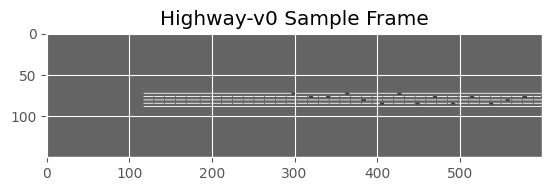

In [10]:
# Visualize highway-v0 environment
print("Visualizing highway-v0 environment...")
env = gym.make('highway-v0', render_mode='rgb_array')
env.unwrapped.config.update({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10,
    "screen_width": 600,
    "screen_height": 150,
    "centering_position": [0.5, 0.5],
    "scaling": 1.0
})
try:
    obs, _ = env.reset()
    frame = env.render()
    print("Highway-v0 Frame shape:", frame.shape if frame is not None else "None")
    print("Frame sample (top-left):", frame[0, 0, :] if frame is not None else "None")
    print("Frame mean:", np.mean(frame) if frame is not None else "None")
    if frame is not None and not np.all(frame == 0):
        imageio.imwrite(os.path.join(path_HW5, 'Videos', 'debug_frame_highway-v0.png'), frame)
        plt.imshow(frame)
        plt.title("Highway-v0 Sample Frame")
        plt.show()
    else:
        print("Warning: Black or empty frame for highway-v0")
except Exception as e:
    print(f"Error during highway-v0 rendering: {str(e)}")
finally:
    env.close()

# Cell 10: Part 2 - Merge-v0

Starting training for Cell 10 (Merge-v0)...
Training agent with state for merge-v0...


Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9952107279693487
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9866432524478502
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9828591362754837
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9838058222831886
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9765055585045967
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9738478527703696
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9714854476732787
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.968906604828355
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9627828824527906
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9530292288469251
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9481907321551211
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9438898462068509
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.94006683647

crashTrue
overFalse
crashTrue
overTrue
Raw Reward: 0.12725156209715682
Episode 1	Avg Reward: 146.55	Epsilon: 0.995crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9952107279693487
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9866432524478502
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9919587531337213
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9928522250077523
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9893360774015268
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9943523753147672
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9906695443410958
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9955376792610506
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9960334926764893
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9921638708848488
crashFalse
overFalse
cras

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9793570165973745
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9806928270137582
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9828380684566739
crashTrue
overFalse
crashTrue
overTrue
Raw Reward: 0.11405529456685187
Episode 2	Avg Reward: 102.93	Epsilon: 0.990crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9952107279693487
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9957428693060877
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9919055390000474
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9918470691494673
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9836533334968446
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9634200437485475
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9622162840983257
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9649776931448718
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9621640797303077
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9515213275763654
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.945892521064049
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9547780263864343
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9545344908875585
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9581494325130788
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9560945147242693
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.946126158682109
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9454071602078518
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9409366328284353
crashFalse
overFalse
crashFalse
overFalse
Raw Reward:

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9296838250259449
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9279181892950928
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9301801529366341
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9278804424570848
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9296676729886731
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9312563223500849
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9369787999433705
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9382340290684367
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9350394434631314
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9360312294384923
crashTrue
overFalse
crashTrue
overTrue
Raw Reward: 0.07915419628249123
Episode 4	Avg Reward: 121.77	Epsilon: 0.980crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9952107279693487
crashFalse
overFalse
cras

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9913793103448276
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9913793103448276
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9913793103448276
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9870689655172413
crashFalse
overFalse
cr

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9746391770864344
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9712309926592061
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9682014953905588
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.969818953757125
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9631149320752989
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9609872193159745
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.959095919085464
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9423387405736875
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9400331259333495
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9298175348090034
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.92885448129667
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9198324729459434
crashTrue
overFalse
crashTrue
overTrue
Raw Reward: 0.06744013054393168
Episode 6	Avg Reward: 108.44	Epsilon: 0.970crashFalse
ove

crashTrue
overFalse
crashTrue
overTrue
Raw Reward: 0.0657408638724069
Episode 7	Avg Reward: 104.82	Epsilon: 0.966crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9952107279693487
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9866432524478502
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9828591362754837
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9838058222831886
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9808159033321829
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9781581975979556
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9757957925008648
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9698644592344853
crashFalse
overFalse
crash

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9446637883027955
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9369233673802627
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9381847556790075
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9354745720978151
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9426440640869468
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9490169458550639
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.945103185587643
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9373139427445716
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9385319337806153
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9357831748547998
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9290294887598219
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9311679746830601
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9249270886071647
crashFalse
overFalse
crashFalse
overFalse
Raw Reward

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9611656540593206
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9581635193777794
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9592948505168578
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9602686428402143
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9654124426892732
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9618105175902029
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.962407517122801
crashTrue
overFalse
crashTrue
overTrue
Raw Reward: 0.10514659291434302
Episode 9	Avg Reward: 109.94	Epsilon: 0.956crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9952107279693487
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9866432524478502
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9871694811030698
crashFalse
overFalse
crash

Iterations: 100%|██████████| 1/1 [00:09<00:00,  9.66s/it]

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9391277756240552
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9320024672213825
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9295002773768611
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9272761086261754
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9343986865949144
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.932109177356399
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9300740580332741
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9282650630793855
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9180363779096453
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9213963205940143
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.919593664282802
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9136809582896936
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9122566372536741
crashFalse
overFalse
crashFalse
overFalse
Raw Reward:

Error in evaluation: name 'max_step' is not defined
Attempting to display video: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4
Video not found: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4. Available videos: []
Generating plot for Cell 10...


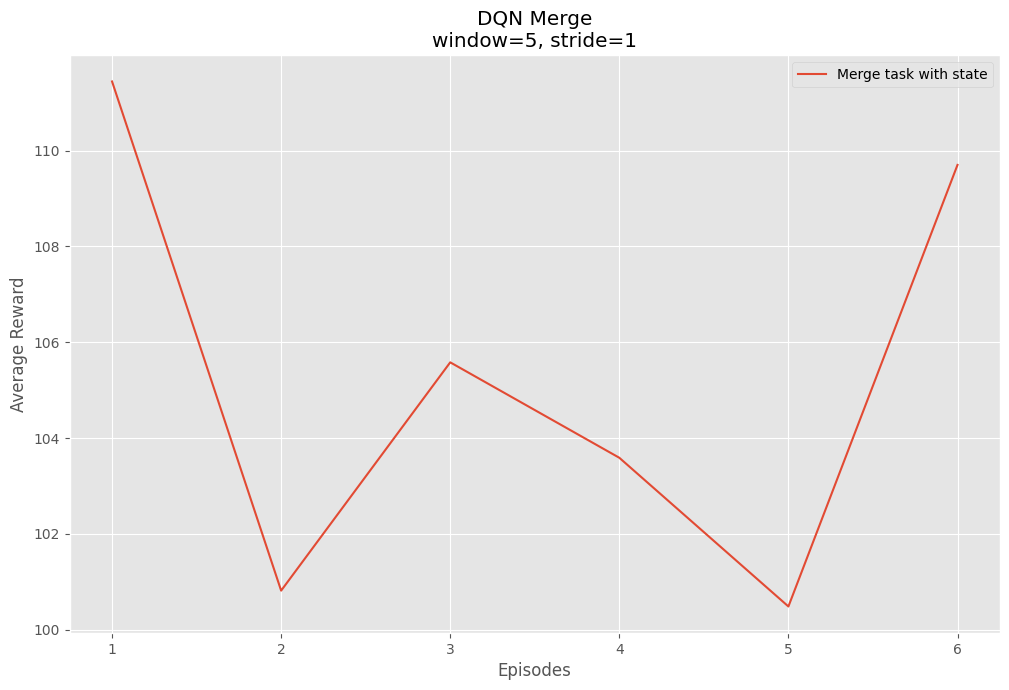

Saving debug frame for Cell 10...


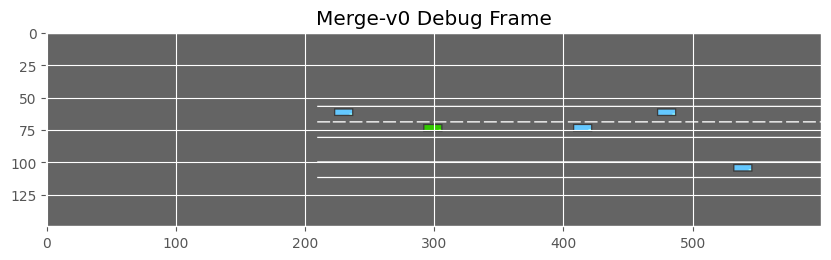

MoviePy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_debug-episode-0.mp4.
MoviePy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_debug-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_debug-episode-0.mp4


In [11]:
# Train and evaluate DQN on merge-v0
video_path = os.path.join(path_HW5, 'Videos')
model_path = os.path.join(path_HW5, 'Models/1_Models_merge')
data_path_1 = os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge')
env_name = 'merge-v0'
env = gym.make(env_name, render_mode='rgb_array')
env.unwrapped.config.update({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10,
    "screen_width": 600,  # Reduced for stability
    "screen_height": 150,  # Reduced for stability
    "centering_position": [0.5, 0.5],
    "scaling": 3.0,  # Reduced to prevent glitches
    "collision_reward": -10.0,
    "high_speed_reward": 1.0,
    "reward_speed_range": [20, 30]
})
dqn_merge = DQN(env, env_name, model_path, data_path_1, 'linear')

# Training
print("Starting training for Cell 10 (Merge-v0)...")
try:
    df_reward_merge = dqn_merge.train_with_state(n_iteration=[1], n_training_episodes=10, max_step=1000)
except Exception as e:
    print(f"Training failed: {str(e)}")

# Evaluation
print("Starting evaluation for Cell 10...")
try:
    avg_reward, crash_rate = dqn_merge.evaluation(os.path.join(video_path, "merge.mp4"), 'state', iter_num=1, evaluate_episode_num=10)
    show_and_plot().show_video(video_path, "merge-v0_eval_ep0-episode-0.mp4")
except Exception as e:
    print(f"Evaluation failed: {str(e)}")

# Plotting
print("Generating plot for Cell 10...")
try:
    df_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_1.xlsx'))
    ep_merge = df_merge.T.to_numpy()
    fig, ax = plt.subplots(figsize=(12, 7.5))
    ax = show_and_plot().plot_training_result(ep_merge, ax, 'DQN Merge', 'Merge task with state', window=5, stride=1)
    plt.legend()
    plt.show()
    fig.savefig(os.path.join(path_HW5, 'Images/1-Merge-task-state.png'), dpi=300)
except Exception as e:
    print(f"Plotting failed: {str(e)}")

# Debug Frame
print("Saving debug frame for Cell 10...")
try:
    env_wrapped = RecordVideo(env, video_folder=video_path, name_prefix="merge-v0_debug")
    state, _ = env_wrapped.reset()
    frame = env_wrapped.render()
    if frame is not None and np.mean(frame) > 0:
        imageio.imwrite(os.path.join(video_path, 'debug_frame_merge-v0.png'), frame)
        plt.figure(figsize=(10, 5))
        plt.imshow(frame)
        plt.title("Merge-v0 Debug Frame")
        plt.show()
    else:
        print("Warning: Black or empty debug frame")
    env_wrapped.close()
except Exception as e:
    print(f"Debug frame failed: {str(e)}")

# Cell 11: Part 3 - Highway-Fast-v0

Starting training for Cell 11...
Training agent with state for highway-fast-v0...


Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

crashFalse
overFalse
Raw Reward: 0.9654654654654655
crashFalse
overFalse
Raw Reward: 0.9454454454454455
crashFalse
overFalse
Raw Reward: 0.9287609807213331
crashFalse
overFalse
Raw Reward: 0.9219093906391023
crashFalse
overFalse
Raw Reward: 0.9192319340840498
crashFalse
overFalse
Raw Reward: 0.9168794210062547
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9125005189549283
crashFalse
overFalse
Raw Reward: 0.9110462480529332
crashFalse
overFalse
Raw Reward: 0.9109051625469583
crashFalse
overFalse
Raw Reward: 0.9107404391038955
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9099099099099099
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9099099099099099
crashFalse
overFalse
Raw Reward: 0.9099099099099099
crashFalse
overFalse
Raw Reward: 0.9241495529169078
crashTrue
overTrue
Raw Reward: 0.018818107480961473
Episode 1	Avg Reward: 15.63	Epsilon: 0.995crashFalse
overFalse
R

crashFalse
overFalse
Raw Reward: 0.9238817007545087
crashFalse
overFalse
Raw Reward: 0.9327435502913702
crashFalse
overFalse
Raw Reward: 0.9348471937980465
crashFalse
overFalse
Raw Reward: 0.9562771006831045
crashFalse
overFalse
Raw Reward: 0.9429311302368354
crashFalse
overFalse
Raw Reward: 0.9243238718977136
crashFalse
overFalse
Raw Reward: 0.9169525655277989
crashFalse
overFalse
Raw Reward: 0.9139143819055275
crashFalse
overFalse
Raw Reward: 0.9117577065427334
crashFalse
overFalse
Raw Reward: 0.9105138561997445
crashFalse
overFalse
Raw Reward: 0.9112601837140908
crashFalse
overFalse
Raw Reward: 0.9113297782532706
crashFalse
overFalse
Raw Reward: 0.911057341217222
crashFalse
overFalse
Raw Reward: 0.9107449772543772
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashTrue
overTrue
Raw Reward: 0.0
Episode 2	Avg Reward: 18.90	Epsilon: 0.990crashFalse
overFalse
Raw Reward: 0.930930930930931
crashFalse
overFalse
Raw Reward: 0.920920

crashFalse
overFalse
Raw Reward: 0.963130692786714
crashFalse
overFalse
Raw Reward: 0.9761928368880814
crashFalse
overFalse
Raw Reward: 0.9861168045400439
crashFalse
overFalse
Raw Reward: 0.9916062167326829
crashFalse
overFalse
Raw Reward: 0.9852125525011104
crashTrue
overTrue
Raw Reward: 0.06378099972543554
Episode 3	Avg Reward: 31.50	Epsilon: 0.985crashFalse
overFalse
Raw Reward: 0.9422947792012156
crashFalse
overFalse
Raw Reward: 0.9172637191603357
crashFalse
overFalse
Raw Reward: 0.9447134410220923
crashFalse
overFalse
Raw Reward: 0.9362263781789553
crashFalse
overFalse
Raw Reward: 0.9296489628362332
crashFalse
overFalse
Raw Reward: 0.917280839982574
crashFalse
overFalse
Raw Reward: 0.911226625225634
crashFalse
overFalse
Raw Reward: 0.9084956000606049
crashFalse
overFalse
Raw Reward: 0.9068662609039706
crashFalse
overFalse
Raw Reward: 0.9072829048666279
crashFalse
overFalse
Raw Reward: 0.9221213023513539
crashFalse
overFalse
Raw Reward: 0.9203548067453716
crashFalse
overFalse
Raw R

crashFalse
overFalse
Raw Reward: 0.9928420663874455
crashFalse
overFalse
Raw Reward: 0.9954310852147807
crashFalse
overFalse
Raw Reward: 0.9819941217664646
crashFalse
overFalse
Raw Reward: 0.9880070456226067
crashFalse
overFalse
Raw Reward: 0.9769923918620007
crashFalse
overFalse
Raw Reward: 0.9696470963320484
crashFalse
overFalse
Raw Reward: 0.9797648303622553
crashFalse
overFalse
Raw Reward: 0.9865099104020427
crashFalse
overFalse
Raw Reward: 0.9910066118753219
crashFalse
overFalse
Raw Reward: 0.9940044088598631
crashFalse
overFalse
Raw Reward: 0.9960029394035381
crashFalse
overFalse
Raw Reward: 0.997335292961217
crashFalse
overFalse
Raw Reward: 0.9982235286442886
crashFalse
overFalse
Raw Reward: 0.9838006707482333
crashFalse
overFalse
Raw Reward: 0.9892004471655158
crashFalse
overFalse
Raw Reward: 0.9928002981103441
crashFalse
overFalse
Raw Reward: 0.9952001987402291
crashFalse
overFalse
Raw Reward: 0.9853709099790438
crashFalse
overFalse
Raw Reward: 0.9735977645157068
crashFalse
ov

crashFalse
overFalse
Raw Reward: 0.9585415667166239
crashFalse
overFalse
Raw Reward: 0.9487891944918618
crashFalse
overFalse
Raw Reward: 0.9358846766617188
crashFalse
overFalse
Raw Reward: 0.9289483028086437
crashFalse
overFalse
Raw Reward: 0.9384992252159605
crashFalse
overFalse
Raw Reward: 0.9444629456867868
crashFalse
overFalse
Raw Reward: 0.9370664028872687
crashFalse
overFalse
Raw Reward: 0.9500030786592386
crashFalse
overFalse
Raw Reward: 0.9510010716435869
crashFalse
overFalse
Raw Reward: 0.9524760299511953
crashFalse
overFalse
Raw Reward: 0.9431538558553421
crashFalse
overFalse
Raw Reward: 0.9302923704221883
crashFalse
overFalse
Raw Reward: 0.9229259903231959
crashFalse
overFalse
Raw Reward: 0.9325972082118148
crashFalse
overFalse
Raw Reward: 0.9220887011259165
crashFalse
overFalse
Raw Reward: 0.942788028502796
crashFalse
overFalse
Raw Reward: 0.9360021744260466
crashFalse
overFalse
Raw Reward: 0.9426612563404203
crashFalse
overFalse
Raw Reward: 0.9640687748094698
crashFalse
ov

Iter 1 Episodes:  50%|█████     | 5/10 [00:01<00:02,  2.29it/s]

crashFalse
overFalse
Raw Reward: 0.954954954954955
crashFalse
overFalse
Raw Reward: 0.9422947792012156
crashFalse
overFalse
Raw Reward: 0.9302053955668632
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.9027759380603053
crashFalse
overFalse
Raw Reward: 0.9198530457150278
crashFalse
overFalse
Raw Reward: 0.9332245410485638
crashFalse
overFalse
Raw Reward: 0.938038820784389
crashFalse
overFalse
Raw Reward: 0.931704775225084
crashFalse
overFalse
Raw Reward: 0.941441982480407
crashFalse
overFalse
Raw Reward: 0.9635666249036183
crashFalse
overFalse
Raw Reward: 0.9471976501293622
crashFalse
overFalse
Raw Reward: 0.9651051146309674
crashFalse
overFalse
Raw Reward: 0.9768562092261088
crashFalse
overFalse
Raw Reward: 0.9545758534350579
crashFalse
overFalse
Raw Reward: 0.9278967927260551
crashFalse
overFalse
Raw Reward: 0.948873137555614
crashTrue
overTrue
Raw Reward: 0.06543131637828957
Episode 6	Avg Reward: 34.97	Epsilon: 0.970crashFalse
overFalse
Raw Rew

crashFalse
overFalse
Raw Reward: 0.9079281895934447
crashFalse
overFalse
Raw Reward: 0.9071027662617889
crashFalse
overFalse
Raw Reward: 0.9065423174029936
crashFalse
overFalse
Raw Reward: 0.9061651357857219
crashFalse
overFalse
Raw Reward: 0.9209274523808186
crashFalse
overFalse
Raw Reward: 0.9164345250020737
crashFalse
overFalse
Raw Reward: 0.9415046942850142
crashFalse
overFalse
Raw Reward: 0.9601177534931433
crashFalse
overFalse
Raw Reward: 0.9721053925553121
crashFalse
overFalse
Raw Reward: 0.9789421868634545
crashFalse
overFalse
Raw Reward: 0.9704957039331851
crashFalse
overFalse
Raw Reward: 0.9577307911183979
crashFalse
overFalse
Raw Reward: 0.9717681056217354
crashFalse
overFalse
Raw Reward: 0.968676947519772
crashFalse
overFalse
Raw Reward: 0.9800223393691793
crashFalse
overFalse
Raw Reward: 0.9870317664592617
crashFalse
overFalse
Raw Reward: 0.9764425532091114
crashFalse
overFalse
Raw Reward: 0.9693020493794117
crashFalse
overFalse
Raw Reward: 0.964524547656165
crashFalse
ove

Iter 1 Episodes:  70%|███████   | 7/10 [00:02<00:01,  2.16it/s]

crashFalse
overFalse
Raw Reward: 0.9422947792012156
crashFalse
overFalse
Raw Reward: 0.95948827704424
crashFalse
overFalse
Raw Reward: 0.9692076987056484
crashFalse
overFalse
Raw Reward: 0.9753373087009053
crashFalse
overFalse
Raw Reward: 0.9810433681321218
crashFalse
overFalse
Raw Reward: 0.9847213397281929
crashFalse
overFalse
Raw Reward: 0.986946429274073
crashFalse
overFalse
Raw Reward: 0.9883335700081051
crashFalse
overFalse
Raw Reward: 0.9892289768509427
crashFalse
overFalse
Raw Reward: 0.9748034521938624
crashFalse
overFalse
Raw Reward: 0.9651846667077961
crashFalse
overFalse
Raw Reward: 0.9560101441769537
crashFalse
overFalse
Raw Reward: 0.9366656885628043
crashFalse
overFalse
Raw Reward: 0.9550538549191384
crashFalse
overFalse
Raw Reward: 0.969265735043531
crashFalse
overFalse
Raw Reward: 0.9779773580563518
crashFalse
overFalse
Raw Reward: 0.9688025188141528
crashFalse
overFalse
Raw Reward: 0.977704859621451
crashFalse
overFalse
Raw Reward: 0.981016104046133
crashTrue
overTrue

crashFalse
overFalse
Raw Reward: 0.9666332999666333
crashFalse
overFalse
Raw Reward: 0.9651479885465114
crashFalse
overFalse
Raw Reward: 0.9494105330425049
crashFalse
overFalse
Raw Reward: 0.9672645727809763
crashFalse
overFalse
Raw Reward: 0.9797250173130805
crashFalse
overFalse
Raw Reward: 0.9853130696409305
crashFalse
overFalse
Raw Reward: 0.9727565730884249
crashFalse
overFalse
Raw Reward: 0.9789567765368058
crashFalse
overFalse
Raw Reward: 0.9679860389069209
crashFalse
overFalse
Raw Reward: 0.9582728525058054
crashFalse
overFalse
Raw Reward: 0.9555522452174635
crashFalse
overFalse
Raw Reward: 0.9368003986241837
crashFalse
overFalse
Raw Reward: 0.9248626658183778
crashFalse
overFalse
Raw Reward: 0.916974642282821
crashFalse
overFalse
Raw Reward: 0.9116694211377545
crashFalse
overFalse
Raw Reward: 0.9081008638130035
crashFalse
overFalse
Raw Reward: 0.9057083596153351
crashFalse
overFalse
Raw Reward: 0.9041084286160386
crashFalse
overFalse
Raw Reward: 0.9030401081823571
crashFalse
ov

Iterations: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]8it/s]


crashFalse
overFalse
Raw Reward: 0.9699699699699701
crashFalse
overFalse
Raw Reward: 0.9799799799799801
crashFalse
overFalse
Raw Reward: 0.974639680924229
crashFalse
overFalse
Raw Reward: 0.9909382931053137
crashFalse
overFalse
Raw Reward: 0.978367087085653
crashFalse
overFalse
Raw Reward: 0.9705928001179642
crashFalse
overFalse
Raw Reward: 0.9558650999076765
crashFalse
overFalse
Raw Reward: 0.967982945709522
crashFalse
overFalse
Raw Reward: 0.9827885645095555
crashFalse
overFalse
Raw Reward: 0.9840179706426453
crashTrue
overTrue
Raw Reward: 0.07139376688964051
Episode 10	Avg Reward: 32.78	Epsilon: 0.951
Starting evaluation for Cell 11...
Error in evaluation: name 'max_step' is not defined
Attempting to display video: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4
Video not found: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-

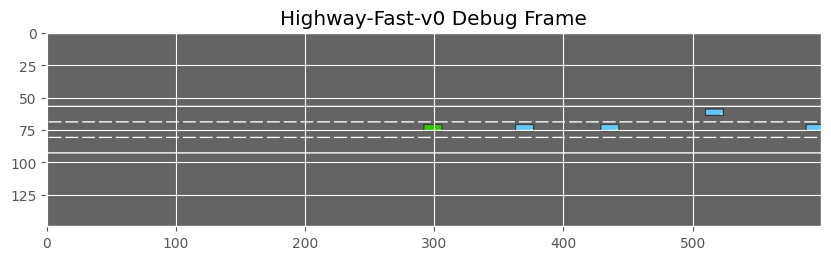

MoviePy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_debug-episode-0.mp4.
MoviePy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_debug-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_debug-episode-0.mp4


In [19]:
# Train and evaluate DQN on highway-fast-v0
video_path = os.path.join(path_HW5, 'Videos')
model_path = os.path.join(path_HW5, 'Models/2_Models_fastHighway')
data_path_2 = os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway')
env_name = 'highway-fast-v0'
env = gym.make(env_name, render_mode='rgb_array')
env.unwrapped.config.update({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 150,
    "centering_position": [0.5, 0.5],
    "scaling": 3.0,
    "collision_reward": -10.0,
    "high_speed_reward": 1.0,
    "reward_speed_range": [20, 30]
})
dqn_fastHighway = DQN(env, env_name, model_path, data_path_2, 'linear')

# Training
print("Starting training for Cell 11...")
try:
    df_reward_fast = dqn_fastHighway.train_with_state(n_iteration=[1], n_training_episodes=10, max_step=1000)
except Exception as e:
    print(f"Training failed: {str(e)}")

# Evaluation
print("Starting evaluation for Cell 11...")
try:
    avg_reward, crash_rate = dqn_fastHighway.evaluation(os.path.join(video_path, "fastHighway.mp4"), 'state', iter_num=1, evaluate_episode_num=10)
    show_and_plot().show_video(video_path, "highway-fast-v0_eval_ep0-episode-0.mp4")
except Exception as e:
    print(f"Evaluation failed: {str(e)}")

# Debug Frame
print("Saving debug frame for Cell 11...")
try:
    env_wrapped = RecordVideo(env, video_folder=video_path, name_prefix="highway-fast-v0_debug")
    state, _ = env_wrapped.reset()
    frame = env_wrapped.render()
    if frame is not None and np.mean(frame) > 0:
        imageio.imwrite(os.path.join(video_path, 'debug_frame_highway-fast-v0.png'), frame)
        plt.figure(figsize=(10, 5))
        plt.imshow(frame)
        plt.title("Highway-Fast-v0 Debug Frame")
        plt.show()
    else:
        print("Warning: Black or empty debug frame")
    env_wrapped.close()
except Exception as e:
    print(f"Debug frame failed: {str(e)}")

# Cell 12: Part 3 - Transfer Learning

Checking for source models for Cell 12...
Starting training for Cell 12...
Training agent with state for highway-fast-v0...


Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

crashFalse
overFalse
Raw Reward: 0.960960960960961
crashFalse
overFalse
Raw Reward: 0.9409409409409409
crashFalse
overFalse
Raw Reward: 0.9242564762168285
crashFalse
overFalse
Raw Reward: 0.9099099099099099
crashFalse
overFalse
Raw Reward: 0.9099099099099099
crashFalse
overFalse
Raw Reward: 0.9112162360198632
crashFalse
overFalse
Raw Reward: 0.9082459931273836
crashFalse
overFalse
Raw Reward: 0.9111212592870556
crashFalse
overFalse
Raw Reward: 0.9102432112565483
crashFalse
overFalse
Raw Reward: 0.9105970295225327
crashFalse
overFalse
Raw Reward: 0.9106335246509704
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9099099099099099
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9099099099099099
crashFalse
overFalse
Raw Reward: 0.9099099099099099
crashFalse
overFalse
Raw Reward: 0.9241424760732354
crashFalse
overFalse
Raw Reward: 0.9197169830353806
crashFalse
overFalse
Raw Reward: 0.916539965556511
crashFalse
ove

crashTrue
overTrue
Raw Reward: 0.015949564338869578
Episode 1	Avg Reward: 29.52	Epsilon: 0.995crashFalse
overFalse
Raw Reward: 0.93993993993994
crashFalse
overFalse
Raw Reward: 0.9299299299299301
crashFalse
overFalse
Raw Reward: 0.9232565899232567
crashFalse
overFalse
Raw Reward: 0.9188076965854745
crashFalse
overFalse
Raw Reward: 0.9158417676936195
crashFalse
overFalse
Raw Reward: 0.9138644817657163
crashFalse
overFalse
Raw Reward: 0.9125462911471142
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.9158306912086458
crashFalse
overFalse
Raw Reward: 0.9259389097256644
crashFalse
overFalse
Raw Reward: 0.92863590966183
crashFalse
overFalse
Raw R

crashFalse
overFalse
Raw Reward: 0.976192836885278
crashTrue
overTrue
Raw Reward: 0.08521590363734516
Episode 2	Avg Reward: 46.18	Epsilon: 0.990crashFalse
overFalse
Raw Reward: 0.9459459459459459
crashFalse
overFalse
Raw Reward: 0.9459459459459459
crashFalse
overFalse
Raw Reward: 0.9459459459459459
crashFalse
overFalse
Raw Reward: 0.9459459459459459
crashFalse
overFalse
Raw Reward: 0.9459459459459459
crashFalse
overFalse
Raw Reward: 0.960960960960961
crashFalse
overFalse
Raw Reward: 0.9409409409409409
crashFalse
overFalse
Raw Reward: 0.9242564762168285
crashFalse
overFalse
Raw Reward: 0.9184476413627396
crashFalse
overFalse
Raw Reward: 0.9120477698865012
crashFalse
overFalse
Raw Reward: 0.9074359315170616
crashFalse
overFalse
Raw Reward: 0.9063393164464246
crashFalse
overFalse
Raw Reward: 0.907087662912019
crashFalse
overFalse
Raw Reward: 0.9220488389240665
crashFalse
overFalse
Raw Reward: 0.920484875798546
crashFalse
overFalse
Raw Reward: 0.9374628380998152
crashFalse
overFalse
Raw Re

crashFalse
overFalse
Raw Reward: 0.9077186815348792
crashTrue
overTrue
Raw Reward: 0.010492237494258077
Episode 3	Avg Reward: 39.80	Epsilon: 0.985

Iter 1 Episodes:  30%|███       | 3/10 [00:01<00:03,  1.75it/s]

crashFalse
overFalse
Raw Reward: 0.9354354354354354
crashFalse
overFalse
Raw Reward: 0.9554554554554555
crashFalse
overFalse
Raw Reward: 0.9648725597649447
crashFalse
overFalse
Raw Reward: 0.9767945385958974
crashFalse
overFalse
Raw Reward: 0.9819177341089417
crashFalse
overFalse
Raw Reward: 0.9852609440516246
crashFalse
overFalse
Raw Reward: 0.9921775457719533
crashFalse
overFalse
Raw Reward: 0.9937681995310521
crashFalse
overFalse
Raw Reward: 0.9964439809871627
crashFalse
overFalse
Raw Reward: 0.99804575445248
crashFalse
overFalse
Raw Reward: 0.9988530735492498
crashFalse
overFalse
Raw Reward: 0.9842671301683169
crashFalse
overFalse
Raw Reward: 0.9895213783753821
crashFalse
overFalse
Raw Reward: 0.9780018780533002
crashFalse
overFalse
Raw Reward: 0.9703201000071229
crashFalse
overFalse
Raw Reward: 0.9802135067705361


crashFalse
overFalse
Raw Reward: 0.9868090309068027
crashFalse
overFalse
Raw Reward: 0.9912060263499312
crashTrue
overTrue
Raw Reward: 0.09323645112965794
Episode 4	Avg Reward: 34.29	Epsilon: 0.980

Iter 1 Episodes:  40%|████      | 4/10 [00:01<00:02,  2.31it/s]

crashFalse
overFalse
Raw Reward: 0.9504504504504505
crashFalse
overFalse
Raw Reward: 0.9467992837057201
crashFalse
overFalse
Raw Reward: 0.9493513408100561
crashFalse
overFalse
Raw Reward: 0.9378617753253063
crashFalse
overFalse
Raw Reward: 0.9591149038180451
crashFalse
overFalse
Raw Reward: 0.9730667699853783
crashFalse
overFalse
Raw Reward: 0.9821470515127361
crashFalse
overFalse
Raw Reward: 0.9768159128573486
crashFalse
overFalse
Raw Reward: 0.967906551393846
crashFalse
overFalse
Raw Reward: 0.9681086191917246
crashFalse
overFalse
Raw Reward: 0.9774509645746263
crashFalse
overFalse
Raw Reward: 0.9854642356068501
crashFalse
overFalse
Raw Reward: 0.990682060807703
crashFalse
overFalse
Raw Reward: 0.9939254460306652
crashFalse
overFalse
Raw Reward: 0.9852924693260218
crashFalse
overFalse
Raw Reward: 0.9880866997419951
crashFalse
overFalse
Raw Reward: 0.991807911219378
crashFalse
overFalse
Raw Reward: 0.9954521632257357
crashFalse
overFalse
Raw Reward: 0.9958175173297442
crashFalse
over

crashFalse
overFalse
Raw Reward: 0.9654654654654655
crashFalse
overFalse
Raw Reward: 0.9754754754754755
crashFalse
overFalse
Raw Reward: 0.9821488154821488
crashFalse
overFalse
Raw Reward: 0.9865977088199311
crashFalse
overFalse
Raw Reward: 0.9869946811659264
crashFalse
overFalse
Raw Reward: 0.9913965314601091
crashFalse
overFalse
Raw Reward: 0.9771903044913446
crashFalse
overFalse
Raw Reward: 0.9682968561977001
crashFalse
overFalse
Raw Reward: 0.9483106057881602
crashFalse
overFalse
Raw Reward: 0.9585318925188646
crashFalse
overFalse
Raw Reward: 0.9479758853483875
crashFalse
overFalse
Raw Reward: 0.9355702291652224
crashFalse
overFalse
Raw Reward: 0.9288435524320986


crashFalse
overFalse
Raw Reward: 0.9384636386396115
crashTrue
overTrue
Raw Reward: 0.043553063138210536
Episode 6	Avg Reward: 29.70	Epsilon: 0.970crashFalse
overFalse
Raw Reward: 0.9422947792012156
crashFalse
overFalse
Raw Reward: 0.9547269124733493
crashFalse
overFalse
Raw Reward: 0.9541931321933934
crashFalse
overFalse
Raw Reward: 0.9545357926858667
crashFalse
overFalse
Raw Reward: 0.9444363911521297
crashFalse
overFalse
Raw Reward: 0.931146419410975
crashFalse
overFalse
Raw Reward: 0.9234975879477797
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.9032639959260762
crashFalse
overFalse
Raw Reward: 0.9054239583828404
crashFalse
overFalse
Raw Reward: 0.9194183703213171
crashFalse
overFalse
Raw Reward: 0.9175274520239958
crashFalse
overFalse
Raw Reward: 0.9330699509556347
crashFalse
overFalse
Raw Reward: 0.9287019818465377
crashFalse
overFalse
Raw Reward: 0.9384297729482702
crashFalse
overFalse
Ra

crashFalse
overFalse
Raw Reward: 0.9508038825327015
crashFalse
overFalse
Raw Reward: 0.9341709954310954
crashFalse
overFalse
Raw Reward: 0.9230812406019699
crashFalse
overFalse
Raw Reward: 0.9156878584368621
crashFalse
overFalse
Raw Reward: 0.9107588901999194
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashTrue
overTrue
Raw Reward: 0.003993841011610396
Episode 7	Avg Reward: 32.03	Epsilon: 0.966

Iter 1 Episodes:  70%|███████   | 7/10 [00:03<00:01,  2.40it/s]

crashFalse
overFalse
Raw Reward: 0.954954954954955
crashFalse
overFalse
Raw Reward: 0.93993993993994
crashFalse
overFalse
Raw Reward: 0.9299299299299301
crashFalse
overFalse
Raw Reward: 0.9232565899232567
crashFalse
overFalse
Raw Reward: 0.9188076965854745
crashFalse
overFalse
Raw Reward: 0.9158417676936195
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9099099099099099
crashFalse
overFalse
Raw Reward: 0.9234851753144282
crashFalse
overFalse
Raw Reward: 0.9346759146231826
crashFalse
overFalse
Raw Reward: 0.9268115120612004
crashFalse
overFalse
Raw Reward: 0.9212848321518574
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9054054054054055
crashFalse
overFalse
Raw Reward: 0.9064597959341367
crashFalse
overFalse
Raw Reward: 0.9068331648583032
crashFalse
overFalse
Raw Reward: 0.9099099099099099
crashFalse
overFalse
Raw Reward: 0.9207214888350602
crashFalse
over

crashTrue
overTrue
Raw Reward: 0.07086720525162381
Episode 8	Avg Reward: 33.25	Epsilon: 0.961crashFalse
overFalse
Raw Reward: 0.930930930930931
crashFalse
overFalse
Raw Reward: 0.950950950950951
crashFalse
overFalse
Raw Reward: 0.9642976309642977
crashFalse
overFalse
Raw Reward: 0.9431653876098322
crashFalse
overFalse
Raw Reward: 0.9290772253735218
crashFalse
overFalse
Raw Reward: 0.9196851172159815
crashFalse
overFalse
Raw Reward: 0.9134237117776213
crashFalse
overFalse
Raw Reward: 0.9092494414853812
crashFalse
overFalse
Raw Reward: 0.9064665946238877
crashFalse
overFalse
Raw Reward: 0.9196263783979071
crashFalse
overFalse
Raw Reward: 0.9283995675805867
crashFalse
overFalse
Raw Reward: 0.9342483603690398
crashFalse
overFalse
Raw Reward: 0.9338739093863905
crashFalse
overFalse
Raw Reward: 0.9541303858168295
crashFalse
overFalse
Raw Reward: 0.9656117757402499
crashFalse
overFalse
Raw Reward: 0.9729507556472092
crashFalse
overFalse
Raw Reward: 0.979487584218439
crashFalse
overFalse
Raw R

crashFalse
overFalse
Raw Reward: 0.9864877168851821
crashTrue
overTrue
Raw Reward: 0.08784464269849772
Episode 9	Avg Reward: 33.73	Epsilon: 0.956crashFalse
overFalse
Raw Reward: 0.9354354354354354
crashFalse
overFalse
Raw Reward: 0.9554554554554555
crashFalse
overFalse
Raw Reward: 0.9387721054387722
crashFalse
overFalse
Raw Reward: 0.9239834112561661
crashFalse
overFalse
Raw Reward: 0.9199623288209727
crashFalse
overFalse
Raw Reward: 0.9145540692898181
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.9009009009009009
crashFalse
overFalse
Raw Reward: 0.901682369875897
crashFalse
overFalse
Raw Reward: 0.9018072129810667
crashFalse
overFalse
Raw Reward: 0.9016372961360783
crashFalse
overFalse
Raw Reward: 0.9014360437598221
crashFalse
overFalse
Raw Reward: 0.9162861335246698
crashFalse
overFalse
Raw Reward: 0.9261785075391691
crashFalse
overFalse
Raw Reward: 0.9327694545960771
crashFalse
overFalse
Raw

crashFalse
overFalse
Raw Reward: 0.9515942964355593
crashFalse
overFalse
Raw Reward: 0.9494421937209307
crashFalse
overFalse
Raw Reward: 0.9358582775546029
crashTrue
overTrue
Raw Reward: 0.05468315323416011
Episode 10	Avg Reward: 33.65	Epsilon: 0.951


Iterations: 100%|██████████| 1/1 [00:05<00:00,  5.07s/it]

Starting evaluation for Cell 12...


Error in evaluation: name 'max_step' is not defined
Attempting to display video: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4
Video not found: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4. Available videos: ['C:\\Users\\Harsh raj\\web\\web-project\\changed_web\\unified_project\\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\\Videos\\highway-fast-v0_debug-episode-0.mp4', 'C:\\Users\\Harsh raj\\web\\web-project\\changed_web\\unified_project\\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\\Videos\\merge-v0_debug-episode-0.mp4']
Generating comparison plot for Cell 12...


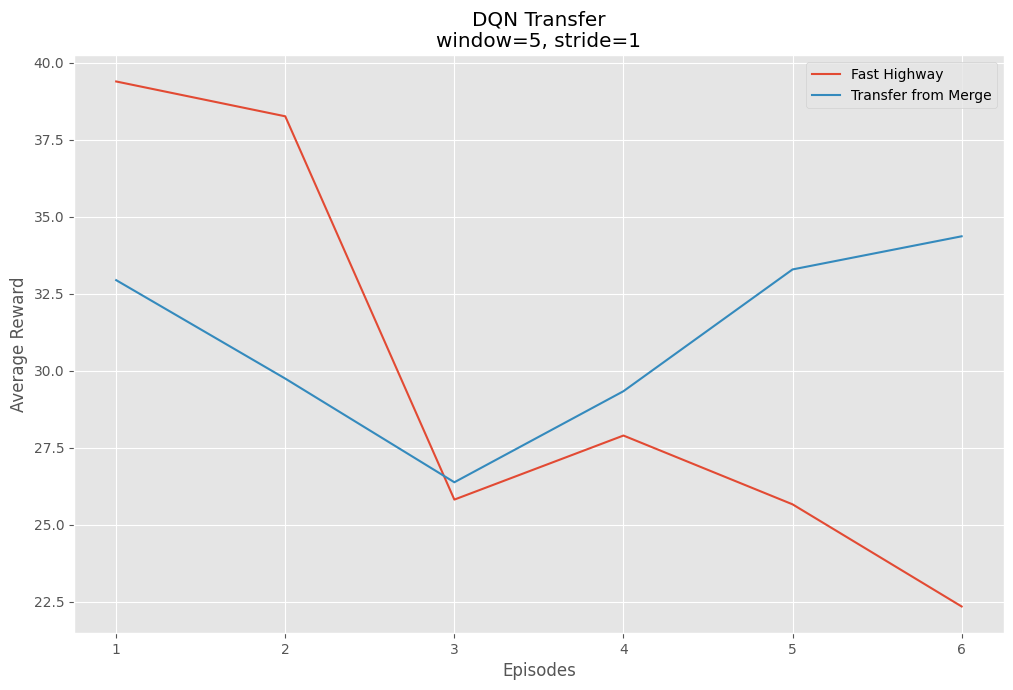

Saving debug frame for Cell 12...


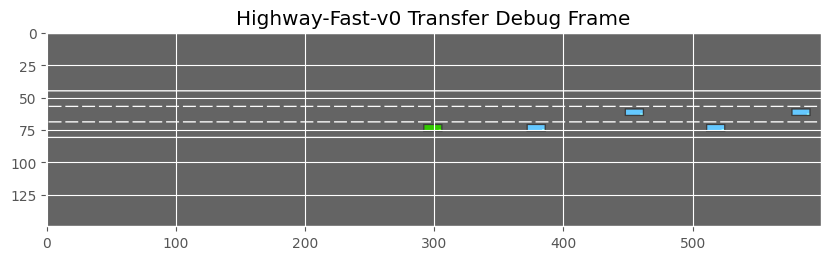

MoviePy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_transfer_debug-episode-0.mp4.
MoviePy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_transfer_debug-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_transfer_debug-episode-0.mp4


In [13]:
# Train and evaluate DQN with transfer learning from merge-v0 to highway-fast-v0
video_path = os.path.join(path_HW5, 'Videos')
model_path_source = os.path.join(path_HW5, 'Models/1_Models_merge')
model_path_dest = os.path.join(path_HW5, 'Models/3_Models_merge_transfer_learning_to_fastHighway')
data_path_3 = os.path.join(path_HW5, 'Data_Average_Reward/3_Data_merge_transfer_learning_to_fastHighway')
env_name_source = 'merge-v0'
env_name = 'highway-fast-v0'
env = gym.make(env_name, render_mode='rgb_array')
env.unwrapped.config.update({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 150,
    "centering_position": [0.5, 0.5],
    "scaling": 3.0,
    "collision_reward": -10.0,
    "high_speed_reward": 1.0,
    "reward_speed_range": [20, 30]
})

# Check source models
print("Checking for source models for Cell 12...")
try:
    local_path = os.path.join(model_path_source, 'Models_Run_1', f'checkpoint_dqn_state_{env_name_source}_local_10.pth')
    target_path = os.path.join(model_path_source, 'Models_Run_1', f'checkpoint_dqn_state_{env_name_source}_target_10.pth')
    if not os.path.exists(local_path) or not os.path.exists(target_path):
        print(f"Error: Source model {local_path} or {target_path} not found. Run Cell 10 first.")
        raise FileNotFoundError(f"Missing {local_path} or {target_path}")
except Exception as e:
    print(f"Source model check failed: {str(e)}")
    raise

dqn_transfer = DQN(env, env_name, model_path_dest, data_path_3, 'linear', env_name_source, model_path_source, transfer_episode=10)

# Training
print("Starting training for Cell 12...")
try:
    df_reward_transfer = dqn_transfer.train_with_state(n_iteration=[1], n_training_episodes=10, max_step=1000)
except Exception as e:
    print(f"Training failed: {str(e)}")

# Evaluation
print("Starting evaluation for Cell 12...")
try:
    avg_reward, crash_rate = dqn_transfer.evaluation(os.path.join(video_path, "fastHighway_transferred_from_merge.mp4"), 'state', iter_num=1, evaluate_episode_num=10)
    show_and_plot().show_video(video_path, "highway-fast-v0_eval_ep0-episode-0.mp4")
except Exception as e:
    print(f"Evaluation failed: {str(e)}")

# Plot Comparison
print("Generating comparison plot for Cell 12...")
try:
    df_fast = pd.read_excel(os.path.join(data_path_2, 'Episodes_reward_run_1.xlsx'))
    df_trans = pd.read_excel(os.path.join(data_path_3, 'Episodes_reward_run_1.xlsx'))
    ep_fast = df_fast.T.to_numpy()
    ep_trans = df_trans.T.to_numpy()
    fig, ax = plt.subplots(figsize=(12, 7.5))
    ax = show_and_plot().plot_training_result(ep_fast, ax, 'DQN Fast', 'Fast Highway', window=5, stride=1)
    ax = show_and_plot().plot_training_result(ep_trans, ax, 'DQN Transfer', 'Transfer from Merge', window=5, stride=1)
    plt.legend()
    plt.show()
    fig.savefig(os.path.join(path_HW5, 'Images/2-fastHighway_with_and_without_transfer_learning_training_on-state.png'), dpi=300)
except Exception as e:
    print(f"Plotting failed: {str(e)}")

# Debug Frame
print("Saving debug frame for Cell 12...")
try:
    env_wrapped = RecordVideo(env, video_folder=video_path, name_prefix="highway-fast-v0_transfer_debug")
    state, _ = env_wrapped.reset()
    frame = env_wrapped.render()
    if frame is not None and np.mean(frame) > 0:
        imageio.imwrite(os.path.join(video_path, 'debug_frame_highway-fast-v0_transfer.png'), frame)
        plt.figure(figsize=(10, 5))
        plt.imshow(frame)
        plt.title("Highway-Fast-v0 Transfer Debug Frame")
        plt.show()
    else:
        print("Warning: Black or empty debug frame")
    env_wrapped.close()
except Exception as e:
    print(f"Debug frame failed: {str(e)}")

# Cell 13: Part 4 - Merge-v0 with CNN and Observation

Starting training for Cell 13...
Training agent with observation for merge-v0...


Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9952107279693487
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9866432524478502
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9828591362754837
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9838058222831886
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9765055585045967
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9738478527703696
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9714854476732787
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.968906604828355
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9627828824527906
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9530292288469251
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9481907321551211
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9438898462068509
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.94006683647

crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9480810825509571
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9538498511564063
crashTrue
overFalse
crashTrue
overTrue
Raw Reward: 0.09259833512753353
Episode 1	Avg Reward: 125.01	Epsilon: 0.995crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 1.0
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9956896551724139
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9952107279693487
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9957428693060877
crashFalse
overFalse
crashFalse
overFals

Episode 2	Avg Reward: 94.20	Epsilon: 0.990crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9952107279693487
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9909535972754363
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.9919587531337213
crashFalse
overFalse
crashFalse
overFalse
Raw Reward: 0.988541880180166


Iterations:   0%|          | 0/1 [00:42<?, ?it/s]


Error in train_with_observation: 'NoneType' object has no attribute 'get_image'
Training failed: 'NoneType' object has no attribute 'get_image'
Starting evaluation for Cell 13...
Error: Models not found at C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Models/4_Models_CNN_merge\Models_Run_1\checkpoint_dqn_observation_merge-v0_local_10.pth or C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Models/4_Models_CNN_merge\Models_Run_1\checkpoint_dqn_observation_merge-v0_target_10.pth
Attempting to display video: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4
Video not found: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-

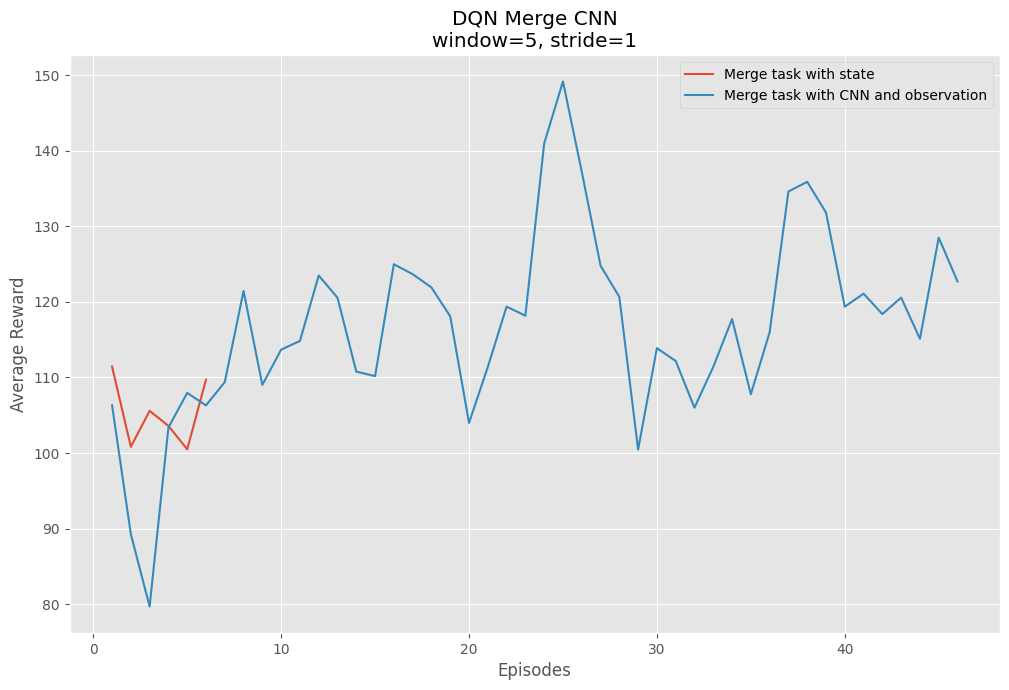

P-value between Merge (state) and Merge (CNN, observation): 0.5836
Saving debug frame for Cell 13...


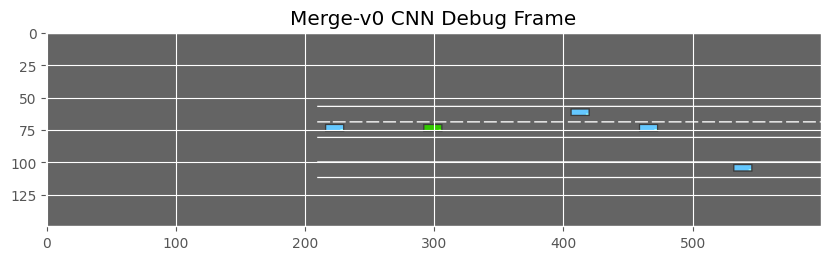

MoviePy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_cnn_debug-episode-0.mp4.
MoviePy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_cnn_debug-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_cnn_debug-episode-0.mp4


In [14]:
# Train and evaluate DQN on merge-v0 using CNN and observation input
video_path = os.path.join(path_HW5, 'Videos')
model_path = os.path.join(path_HW5, 'Models/4_Models_CNN_merge')
data_path_4 = os.path.join(path_HW5, 'Data_Average_Reward/4_Data_CNN_merge')
env_name = 'merge-v0'
env = gym.make(env_name, render_mode='rgb_array')
env.unwrapped.config.update({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10,
    "screen_width": 600,
    "screen_height": 150,
    "centering_position": [0.5, 0.5],
    "scaling": 3.0,
    "collision_reward": -10.0,
    "high_speed_reward": 1.0,
    "reward_speed_range": [20, 30]
})
dqn_merge_cnn = DQN(env, env_name, model_path, data_path_4, 'cnn')

# Training
print("Starting training for Cell 13...")
try:
    df_reward_merge_cnn = dqn_merge_cnn.train_with_observation(n_iteration=[1], n_training_episodes=10, max_step=1000)
except Exception as e:
    print(f"Training failed: {str(e)}")

# Evaluation
print("Starting evaluation for Cell 13...")
try:
    avg_reward, crash_rate = dqn_merge_cnn.evaluation(os.path.join(video_path, "merge_observation_CNN.mp4"), 'observation', iter_num=1, evaluate_episode_num=10)
    show_and_plot().show_video(video_path, "merge-v0_eval_ep0-episode-0.mp4")
except Exception as e:
    print(f"Evaluation failed: {str(e)}")

# Plotting
print("Generating plot for Cell 13...")
try:
    df_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_1.xlsx'))
    df_merge_cnn = pd.read_excel(os.path.join(data_path_4, 'Episodes_reward_run_1.xlsx'))
    ep_merge = df_merge.T.to_numpy()
    ep_merge_cnn = df_merge_cnn.T.to_numpy()
    fig, ax = plt.subplots(figsize=(12, 7.5))
    ax = show_and_plot().plot_training_result(ep_merge, ax, 'DQN Merge', 'Merge task with state', window=5, stride=1)
    ax = show_and_plot().plot_training_result(ep_merge_cnn, ax, 'DQN Merge CNN', 'Merge task with CNN and observation', window=5, stride=1)
    plt.legend()
    plt.show()
    fig.savefig(os.path.join(path_HW5, 'Images/3-merge_cnn_observation_merge_linear_state.png'), dpi=300)
except Exception as e:
    print(f"Plotting failed: {str(e)}")

# Statistical Significance
try:
    t_test = ttest_ind(np.mean(ep_merge, axis=0), np.mean(ep_merge_cnn, axis=0))
    print(f"P-value between Merge (state) and Merge (CNN, observation): {t_test.pvalue:.4f}")
except Exception as e:
    print(f"Statistical test failed: {str(e)}")

# Debug Frame
print("Saving debug frame for Cell 13...")
try:
    env_wrapped = RecordVideo(env, video_folder=video_path, name_prefix="merge-v0_cnn_debug")
    state, _ = env_wrapped.reset()
    frame = env_wrapped.render()
    if frame is not None and np.mean(frame) > 0:
        imageio.imwrite(os.path.join(video_path, 'debug_frame_merge-v0_cnn.png'), frame)
        plt.figure(figsize=(10, 5))
        plt.imshow(frame)
        plt.title("Merge-v0 CNN Debug Frame")
        plt.show()
    else:
        print("Warning: Black or empty debug frame")
    env_wrapped.close()
except Exception as e:
    print(f"Debug frame failed: {str(e)}")

# Cell 14: Statistical Significance Check for Highway-Fast-v0

In [15]:
# Compare highway-fast-v0 with and without transfer learning
df_fast = pd.read_excel(os.path.join(data_path_2, 'Episodes_reward_run_5.xlsx'))
df_trans = pd.read_excel(os.path.join(data_path_3, 'Episodes_reward_run_5.xlsx'))
ep_fast = df_fast.T.to_numpy()
ep_trans = df_trans.T.to_numpy()
t_test = ttest_ind(np.mean(ep_fast, axis=0), np.mean(ep_trans, axis=0))
print(f"P-value between fastHighway and transferred: {t_test.pvalue:.4f}")

P-value between fastHighway and transferred: 0.1385


# Cell 15: Multi-Agent Extension Setup

In [16]:
# Define CACC environment wrapper
from gymnasium import Wrapper

class CACCWrapper(Wrapper):
    def __init__(self, env, target_gap=5.0):
        super().__init__(env)
        self.target_gap = target_gap
        self.num_agents = env.unwrapped.config.get('controlled_vehicles', 1)

    def step(self, action):
        obs, rewards, terminateds, truncateds, infos = self.env.step(action)
        new_rewards = {}
        for agent_id in obs:
            state = obs[agent_id]
            own_pos = state[0, 1]  # x-position
            own_vel = state[0, 3]  # vx
            gap_penalty = 0
            collision_penalty = 0
            accel_penalty = 0
            for i in range(1, state.shape[0]):
                if state[i, 0] == 1:  # Vehicle present
                    rel_x = state[i, 1] - own_pos
                    if 0 < rel_x < 10:  # Ahead
                        gap_error = abs(rel_x - self.target_gap)
                        gap_penalty += -gap_error
                        if rel_x < 2:
                            collision_penalty = -10
            accel_penalty = -0.1 * (action[agent_id] - 2)**2  # Action 2 = idle
            new_rewards[agent_id] = rewards[agent_id] + gap_penalty + collision_penalty + accel_penalty
        return obs, new_rewards, terminateds, truncateds, infos

# Cell 16: Multi-Agent DQN for CACC

In [17]:
# Define multi-agent DQN for CACC
class MultiAgentDQN:
    def __init__(self, env, env_name, model_path, data_path, network_type, num_agents=4, pretrained_path=None):
        self.env = CACCWrapper(env.unwrapped)
        self.env_name = env_name
        self.model_path = model_path
        self.data_path = data_path
        self.network_type = network_type
        self.num_agents = num_agents
        self.agents = [Agent(int(np.prod(self.env.observation_space[0].shape)), self.env.action_space[0].n, network_type, seed=11+i) for i in range(num_agents)]
        self.df_reward = pd.DataFrame()
        self.seed = [0, 5, 11, 123, 487]
        if pretrained_path:
            for agent in self.agents:
                agent.qnetwork_local.load_state_dict(torch.load(pretrained_path, map_location=device))
                agent.qnetwork_target.load_state_dict(torch.load(pretrained_path.replace('local', 'target'), map_location=device))

    def train(self, n_iteration, n_training_episodes=50, max_step=10000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print("Training multi-agent CACC...")
        for iter in tqdm(n_iteration, desc="Iterations"):
            episodes_reward = [[] for _ in range(self.num_agents)]
            os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
            eps = eps_start

            for episode_num in tqdm(range(1, n_training_episodes + 1), desc=f"Iter {iter} Episodes", leave=False):
                obs_dict, _ = self.env.reset()
                done_dict = {i: False for i in range(self.num_agents)}
                total_rewards = [0] * self.num_agents
                for _ in range(max_step):
                    actions_dict = {i: self.agents[i].act(obs_dict[i].ravel(), eps) for i in range(self.num_agents)}
                    next_obs, rewards, terminateds, truncateds, _ = self.env.step(actions_dict)
                    for i in range(self.num_agents):
                        if not done_dict[i]:
                            self.agents[i].step(obs_dict[i].ravel(), actions_dict[i], rewards[i], next_obs[i].ravel(), terminateds[i] or truncateds[i])
                            total_rewards[i] += rewards[i]
                            done_dict[i] = terminateds[i] or truncateds[i]
                    obs_dict = next_obs
                    if all(done_dict.values()):
                        break
                for i in range(self.num_agents):
                    episodes_reward[i].append(total_rewards[i])
                eps = max(eps_end, eps_decay * eps)
                print(f'\rEpisode {episode_num}\tAvg Reward: {[np.mean(episodes_reward[i]):.2f for i in range(self.num_agents)]}\tEpsilon: {eps:.3f}', end='')
                if episode_num % 10 == 0:
                    print(f'\rEpisode {episode_num}\tAvg Reward: {[np.mean(episodes_reward[i]):.2f for i in range(self.num_agents)]}\tEpsilon: {eps:.3f}')
                if episode_num % 200 == 0:
                    for i, agent in enumerate(self.agents):
                        torch.save(agent.qnetwork_local.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'agent_{i}_local_{episode_num}.pth'))
                        torch.save(agent.qnetwork_target.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'agent_{i}_target_{episode_num}.pth'))

            for i in range(self.num_agents):
                self.df_reward[f'Run_{iter}_Agent_{i}'] = episodes_reward[i]
            self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
        return self.df_reward

    def evaluate(self, video_file, iter_num, evaluate_episode_num, num_episodes=5):
        video_dir = os.path.dirname(video_file)
        os.makedirs(video_dir, exist_ok=True)
        os.environ["SDL_VIDEODRIVER"] = "windows"
        total_rewards = [0] * self.num_agents
        crashes = [0] * self.num_agents
        for ep in range(num_episodes):
            env_wrapped = RecordVideo(self.env, video_folder=video_dir, name_prefix=f"cacc_eval_ep{ep}")
            obs_dict, _ = env_wrapped.reset()
            done_dict = {i: False for i in range(self.num_agents)}
            ep_rewards = [0] * self.num_agents
            while not all(done_dict.values()):
                actions_dict = {i: self.agents[i].act(obs_dict[i].ravel(), eps=0) for i in range(self.num_agents)}
                next_obs, rewards, terminateds, truncateds, infos = env_wrapped.step(actions_dict)
                for i in range(self.num_agents):
                    if not done_dict[i]:
                        ep_rewards[i] += rewards[i]
                        if 'crashed' in infos[i] and infos[i]['crashed']:
                            crashes[i] += 1
                        done_dict[i] = terminateds[i] or truncateds[i]
                obs_dict = next_obs
            env_wrapped.close()
            for i in range(self.num_agents):
                total_rewards[i] += ep_rewards[i]
                print(f"Episode {ep+1} Agent {i} Reward: {ep_rewards[i]:.2f}")
        avg_rewards = [total_rewards[i] / num_episodes for i in range(self.num_agents)]
        crash_rates = [crashes[i] / num_episodes for i in range(self.num_agents)]
        print(f"Average Rewards: {avg_rewards}")
        print(f"Crash Rates: {crash_rates}")
        pd.DataFrame({
            'Episode': list(range(1, num_episodes+1)),
            **{f'Agent_{i}_Reward': [ep_rewards[i] for ep in range(num_episodes)] for i in range(self.num_agents)}
        }).to_csv(os.path.join(video_dir, f"{self.env_name}_cacc_eval_rewards.csv"), index=False)
        return avg_rewards, crash_rates

SyntaxError: f-string: expecting a valid expression after '{' (2813304776.py, line 43)

# Cell 17: Run MARL-CACC

In [ ]:
# Train and evaluate multi-agent DQN for CACC
video_path = os.path.join(path_HW5, 'Videos')
model_path_cacc = os.path.join(path_HW5, 'Models/5_Models_CACC')
data_path_cacc = os.path.join(path_HW5, 'Data_Average_Reward/5_Data_CACC')
env_name = 'highway-v0'
env = gym.make(env_name, render_mode='rgb_array')
env.unwrapped.config.update({
    'controlled_vehicles': 4,
    'observation': {
        'type': 'Kinematics',
        'vehicles_count': 5,
        'features': ['presence', 'x', 'y', 'vx', 'vy']
    },
    'policy_frequency': 5
})

# Initialize with transfer learning from highway-fast-v0
dqn_cacc = MultiAgentDQN(
    env, env_name, model_path_cacc, data_path_cacc, 'linear', num_agents=4,
    pretrained_path=os.path.join(path_HW5, 'Models/2_Models_fastHighway/Models_Run_5/checkpoint_dqn_state_highway-fast-v0_local_50.pth')
)

# Training
print("Starting training for Cell 17...")
df_reward_cacc = dqn_cacc.train(n_iteration=[1,2,3,4,5], n_training_episodes=50, max_step=10000)

# Evaluation
print("Starting evaluation for Cell 17...")
avg_rewards, crash_rates = dqn_cacc.evaluate(os.path.join(video_path, "cacc.mp4"), iter_num=5, evaluate_episode_num=50)

# Plotting
print("Generating plot for Cell 17...")
df_cacc = pd.read_excel(os.path.join(data_path_cacc, 'Episodes_reward_run_5.xlsx'))
ep_cacc = df_cacc.T.to_numpy()
fig, ax = plt.subplots(figsize=(12, 7.5))
for i in range(4):
    ax = show_and_plot().plot_training_result(ep_cacc[i::4], ax, 'MARL-CACC', f'Agent {i}', window=10, stride=2)
plt.legend()
plt.show()
fig.savefig(os.path.join(path_HW5, 'Images/5-CACC-Rewards.png'), dpi=300)
show_and_plot().show_video(video_path, "cacc_eval_ep0-episode-0.mp4")

# Cell 18: Statistical Significance Check for CACC

In [ ]:
# Compare CACC with transferred highway-fast-v0
df_trans = pd.read_excel(os.path.join(data_path_3, 'Episodes_reward_run_5.xlsx'))
df_cacc = pd.read_excel(os.path.join(data_path_cacc, 'Episodes_reward_run_5.xlsx'))
ep_trans = df_trans.T.to_numpy()
ep_cacc = df_cacc.T.to_numpy()
t_test = ttest_ind(np.mean(ep_trans, axis=0), np.mean(ep_cacc[0::4], axis=0))
print(f"P-value between transferred fastHighway and CACC Agent 0: {t_test.pvalue:.4f}")